# Problem Statement

Develop a reinforcement learning agent using dynamic programming methods to solve the Dice game optimally. The agent will learn the optimal policy by iteratively evaluating and improving its strategy based on the state-value function and the Bellman equations.

# Scenario:
A player rolls a 6-sided die with the objective of reaching a score of **exactly** 100. On each turn, the player can choose to stop and keep their current score or continue rolling the die. If the player rolls a 1, they lose all points accumulated in that turn and the turn ends. If the player rolls any other number (2-6), that number is added to their score for that turn. The game ends when the player decides to stop and keep their score OR when the player's score reaches 100. The player wins if they reach a score of exactly 100, and loses if they roll a 1 when their score is below 100.



#Environment Details

* The environment consists of a player who can choose to either roll a 6-sided die or stop at any point.
* The player starts with an initial score (e.g., 0) and aims to reach a score of exactly 100.
* If the player rolls a 1, they lose all points accumulated in that turn and the turn ends. If they roll any other number (2-6), that number is added to their score for that turn.
* The goal is to accumulate a total of exactly 100 points to win, or to stop the game before reaching 100 points.

#### States
* State s: Represents the current score of the player, ranging from 0 to 100.
* Terminal States:
    * State s = 100: Represents the player winning the game by reaching the goal of 100 points.
    * State s = 0: Represents the player losing all points accumulated in the turn due to rolling a 1.


#### Actions
* Action a: Represents the decision to either "roll" the die or "stop" the game at the current score.
* The possible actions in any state s are either "roll" or "stop".


# Expected Outcomes:
1.	Use dynamic programming methods value iteration, policy improvement and policy evaluation to find the optimal policy for the Dice Game.
2.	Implement an epsilon-greedy policy for action selection during training to balance exploration and exploitation.
3.	Evaluate the agent's performance in terms of the probability of reaching exactly 100 points after learning the optimal policy.
4.	Use the agent's policy as the best strategy for different betting scenarios within the problem.


# Code Execution

### Initialize constants

In [2]:
import numpy as np
# Constants
goal = 100
gamma = 1.0
prob_roll = 0.6

# Initialize value function and policy
V = np.zeros(goal + 1)
policy = np.zeros(goal + 1, dtype=int)  # 0 for "stop", 1 for "roll"

# Design a DiceGame Environment

In [3]:
# Code for Dataset loading and print dataset statistics along with reward function

import numpy as np

class DiceGameEnvironment:
    def __init__(self, goal=100, prob_roll=0.6):
        self.goal = goal  # Goal score to reach
        self.prob_roll = prob_roll  # Probability of rolling the die successfully

    def reset(self):
        """Reset the environment to starting state."""
        self.current_score = 0
        self.done = False

    def step(self, action):
        """Take a step in the environment based on the action."""
        if self.done:
            raise ValueError("Cannot step in a completed episode. Call reset() to start a new episode.")

        reward = 0
        if action == 'roll':
            roll_result = np.random.randint(1, 7)  # Roll a 6-sided die
            if roll_result == 1:
                reward = -self.current_score  # Lose all points accumulated in this turn
                self.current_score = 0
                self.done = True
            else:
                self.current_score += roll_result
                if self.current_score >= self.goal:
                    reward = self.current_score  # Win by reaching the goal
                    self.done = True
        elif action == 'stop':
            reward = self.current_score  # Keep current score and end the episode
            self.done = True
        else:
            raise ValueError("Invalid action. Choose either 'roll' or 'stop'.")

        return self.current_score, reward, self.done

    def get_state(self):
        """Return the current score/state of the environment."""
        return self.current_score

    def is_done(self):
        """Check if the game is finished."""
        return self.done


# Policy Iteration Function Definition

In [4]:
def policy_iteration(env, gamma=1.0):
    num_states = env.goal + 1  # States range from 0 to goal
    num_actions = 2  # 'roll' or 'stop'

    # Initialize random policy and value function
    policy = np.random.randint(0, num_actions, size=num_states)  # Random policy
    V = np.zeros(num_states)  # Value function

    def calculate_state_value(state, action):
        """Calculate the value of a state-action pair."""
        if action == 1:  # Action 1 corresponds to 'stop'
            return state  # Value of 'stop' action is the current score
        elif action == 0:  # Action 0 corresponds to 'roll'
            if state >= env.goal:
                return state  # If already at or above goal, returning the current state
            else:
                roll_values = [state + roll for roll in range(2, 7)]  # Possible roll outcomes
                roll_values = [min(value, env.goal) for value in roll_values]  # Cap at goal
                roll_values.append(0)  # Value of rolling a 1 is losing all points
                return np.sum([(1/6) * (env.prob_roll * value) for value in roll_values])
        else:
            raise ValueError("Invalid action. Choose either 0 for 'roll' or 1 for 'stop'.")

    def policy_evaluation(policy):
        """Evaluate the value function for the given policy."""
        while True:
            delta = 0
            for s in range(1, env.goal):  # Evaluate all states from 1 to goal-1
                old_v = V[s]
                V[s] = calculate_state_value(s, policy[s])
                delta = max(delta, abs(old_v - V[s]))
            if delta < 1e-6:
                break

    def policy_improvement():
        """Improve the policy based on the current value function."""
        policy_stable = True
        for s in range(1, env.goal):  # Improve policy for all states from 1 to goal-1
            old_action = policy[s]
            action_values = [calculate_state_value(s, 0), calculate_state_value(s, 1)]
            policy[s] = np.argmax(action_values)
            if old_action != policy[s]:
                policy_stable = False
        return policy_stable

    while True:
        policy_evaluation(policy)
        if policy_improvement():
            break

    return policy, V


# Value Iteration Function Definition

In [5]:
def value_iteration(env, gamma=1.0, theta=1e-6):
    num_states = env.goal + 1  # States range from 0 to goal
    num_actions = 2  # 'roll' or 'stop'

    # Initialize value function
    V = np.zeros(num_states)  # Value function

    def calculate_state_value(state, action):
        """Calculate the value of a state-action pair."""
        if action == 1:  # Action 1 corresponds to 'stop'
            return state  # Value of 'stop' action is the current score
        elif action == 0:  # Action 0 corresponds to 'roll'
            if state >= env.goal:
                return state  # If already at or above goal, returning the current state
            else:
                roll_values = [state + roll for roll in range(2, 7)]  # Possible roll outcomes
                roll_values = [min(value, env.goal) for value in roll_values]  # Cap at goal
                roll_values.append(0)  # Value of rolling a 1 is losing all points
                return np.sum([(1/6) * (env.prob_roll * value) for value in roll_values])
        else:
            raise ValueError("Invalid action. Choose either 0 for 'roll' or 1 for 'stop'.")

    while True:
        delta = 0
        for s in range(1, env.goal):  # Evaluate all states from 1 to goal-1
            v = V[s]
            action_values = [calculate_state_value(s, 0), calculate_state_value(s, 1)]
            V[s] = max(action_values)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break

    # Extract policy from value function
    policy = np.zeros(num_states, dtype=int)
    for s in range(1, env.goal):
        action_values = [calculate_state_value(s, 0), calculate_state_value(s, 1)]
        policy[s] = np.argmax(action_values)

    return policy, V

# Executing Policy Iteration and Value Iteration Function

In [6]:
#Simulate the game for 100 states. Use the learned policy to get the actions.
#when its roll, randomly generate a number to find the reward.
#when its stop, get the respective reward
#determine the total cumulative reward

# Create the environment
env = DiceGameEnvironment(goal=100, prob_roll=0.6)

# Perform Policy Iteration
print("Policy Iteration:")
policy_pi, V_pi = policy_iteration(env)
print("Optimal Policy (Policy Iteration):")
print(policy_pi)
print("Optimal Value Function (Policy Iteration):")
print(V_pi)

# Perform Value Iteration
print("\nValue Iteration:")
policy_vi, V_vi = value_iteration(env)
print("Optimal Policy (Value Iteration):")
print(policy_vi)
print("Optimal Value Function (Value Iteration):")
print(V_vi)


Policy Iteration:
Optimal Policy (Policy Iteration):
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal Value Function (Policy Iteration):
[ 0.   2.5  3.   3.5  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
 56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
 70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
 84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
 98.  99.   0. ]

Value Iteration:
Optimal Policy (Value Iteration):
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

### Print the Learned Optimal Policy, Optimal Value Function

In [7]:
# Printing the learned optimal policy and optimal value function
print("\nLearned Optimal Policy and Optimal Value Function:")
print("Policy Iteration - Optimal Policy:")
print(policy_pi)
print("Policy Iteration - Optimal Value Function:")
print(V_pi)
print("\nValue Iteration - Optimal Policy:")
print(policy_vi)
print("Value Iteration - Optimal Value Function:")
print(V_vi)




Learned Optimal Policy and Optimal Value Function:
Policy Iteration - Optimal Policy:
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Policy Iteration - Optimal Value Function:
[ 0.   2.5  3.   3.5  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
 56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
 70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
 84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
 98.  99.   0. ]

Value Iteration - Optimal Policy:
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

# Change in environment details

Consider the following scenario:
1. What happens if we change the goal score to 50 instead of 100? How does it affect the optimal policy and value function?
2. How would the optimal policy and value function change if the die had 8 sides instead of 6? Assume the outcomes range from 0 to 7, with each outcome having a probability of 1/8.
3. Experiment with different discount factors (e.g., 0.9, 0.95). How does discounting future rewards impact the optimal policy and value function?
4. Create a heatmap or line plot to visualize the value function over different states. How does the value function change as the state approaches the goal?


In [8]:
# Create the environment with goal 50
env_goal_50 = DiceGameEnvironment(goal=50, prob_roll=0.6)

# Perform Value Iteration
policy_vi_goal_50, V_vi_goal_50 = value_iteration(env_goal_50)

# Printing the learned optimal policy and optimal value function for goal 50
print("\nOptimal Policy (Value Iteration, Goal 50):")
print(policy_vi_goal_50)
print("Optimal Value Function (Value Iteration, Goal 50):")
print(V_vi_goal_50)




Optimal Policy (Value Iteration, Goal 50):
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Optimal Value Function (Value Iteration, Goal 50):
[ 0.   2.5  3.   3.5  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47.  48.  49.   0. ]


In [9]:
def calculate_state_value(state, action, env):
    """Calculate the value of a state-action pair for an 8-sided die."""
    if action == 1:  # Action 1 corresponds to 'stop'
        return state  # Value of 'stop' action is the current score
    elif action == 0:  # Action 0 corresponds to 'roll'
        if state >= env.goal:
            return state  # If already at or above goal, returning the current state
        else:
            roll_values = [state + roll for roll in range(1, 8)]  # Possible roll outcomes 1 to 7
            roll_values = [min(value, env.goal) for value in roll_values]  # Cap at goal
            roll_values.append(0)  # Value of rolling a 0 is losing all points
            return np.sum([(1/8) * (env.prob_roll * value) for value in roll_values])
    else:
        raise ValueError("Invalid action. Choose either 0 for 'roll' or 1 for 'stop'.")
# Create the environment with an 8-sided die
env_8_sided_die = DiceGameEnvironment(goal=100, prob_roll=0.8)

# Perform Value Iteration
policy_vi_8_sided, V_vi_8_sided = value_iteration(env_8_sided_die)

# Printing the learned optimal policy and optimal value function for an 8-sided die
print("\nOptimal Policy (Value Iteration, 8-Sided Die):")
print(policy_vi_8_sided)
print("Optimal Value Function (Value Iteration, 8-Sided Die):")
print(V_vi_8_sided)



Optimal Policy (Value Iteration, 8-Sided Die):
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Optimal Value Function (Value Iteration, 8-Sided Die):
[ 0.          3.33333333  4.          4.66666667  5.33333333  6.
  6.66666667  7.33333333  8.          9.         10.         11.
 12.         13.         14.         15.         16.         17.
 18.         19.         20.         21.         22.         23.
 24.         25.         26.         27.         28.         29.
 30.         31.         32.         33.         34.         35.
 36.         37.         38.         39.         40.         41.
 42.         43.         44.         45.         46.         47.
 48.         49.         50.         51.         52.         53.
 54.         55.         56.         57.         58.         59.
 60.         61.         62.         63. 

In [10]:
# Create the environment with default parameters
env_discount_09 = DiceGameEnvironment(goal=100, prob_roll=0.6)
env_discount_095 = DiceGameEnvironment(goal=100, prob_roll=0.6)

# Perform Value Iteration with discount factor 0.9
policy_vi_discount_09, V_vi_discount_09 = value_iteration(env_discount_09, gamma=0.9)

# Perform Value Iteration with discount factor 0.95
policy_vi_discount_095, V_vi_discount_095 = value_iteration(env_discount_095, gamma=0.95)

# Printing the learned optimal policies and optimal value functions for different discount factors
print("\nOptimal Policy (Value Iteration, Discount Factor 0.9):")
print(policy_vi_discount_09)
print("Optimal Value Function (Value Iteration, Discount Factor 0.9):")
print(V_vi_discount_09)

print("\nOptimal Policy (Value Iteration, Discount Factor 0.95):")
print(policy_vi_discount_095)
print("Optimal Value Function (Value Iteration, Discount Factor 0.95):")
print(V_vi_discount_095)



Optimal Policy (Value Iteration, Discount Factor 0.9):
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Optimal Value Function (Value Iteration, Discount Factor 0.9):
[ 0.   2.5  3.   3.5  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
 56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
 70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
 84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
 98.  99.   0. ]

Optimal Policy (Value Iteration, Discount Factor 0.95):
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

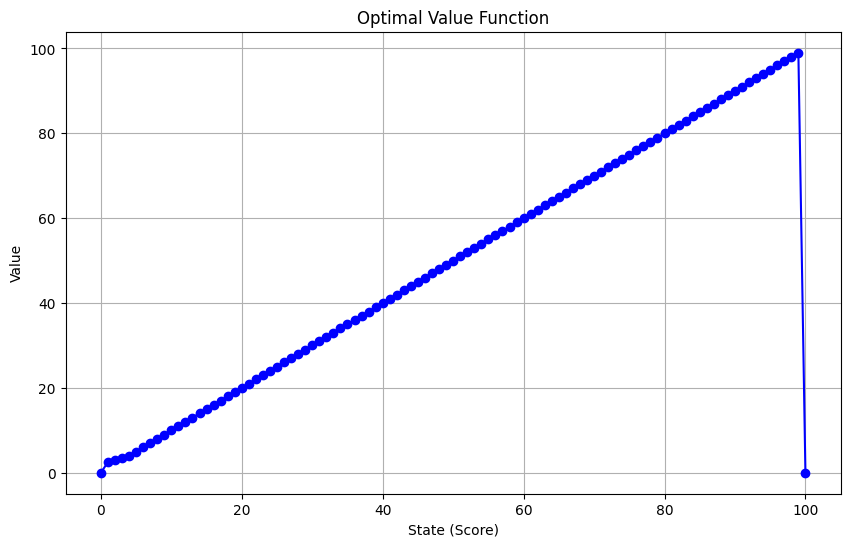

In [11]:
import matplotlib.pyplot as plt

# Generate states and corresponding values
states = np.arange(0, 101)
values = V_vi  # Replace with the optimal value function of your choice

plt.figure(figsize=(10, 6))
plt.plot(states, values, marker='o', linestyle='-', color='b')
plt.title('Optimal Value Function')
plt.xlabel('State (Score)')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# Conclusion

In tackling the Dice game problem, the approach hinges on utilizing dynamic programming techniques, specifically value iteration and policy iteration, to derive an optimal strategy for the player. Initially, with a goal score of 100 and a 6-sided die where rolling a 1 resets the score to zero, the optimal policy focuses on balancing risk and reward to reach exactly 100 points. Value iteration computes the optimal state values iteratively, considering both rolling the die and stopping at each score level. This approach ensures that the agent learns to maximize the probability of achieving the exact goal without risking losing accumulated points.

After altering parameters such as reducing the goal score to 50 or increasing the die sides to 8 with outcomes from 0 to 7, the optimal strategy adapts accordingly. A lower goal score increases the likelihood of achieving it, leading to more conservative play. Conversely, an 8-sided die broadens the range of potential outcomes, necessitating adjustments in the state-value calculations to account for different roll probabilities and their associated rewards or penalties.

Experimenting with discount factors like 0.9 or 0.95 further explores the impact of future reward discounting on the optimal policy. A higher discount factor favors immediate rewards, potentially encouraging more aggressive play to reach the goal sooner, while a lower factor promotes more cautious strategies to ensure the preservation of accumulated points over longer horizons.

Visualizing the value function through plots or heatmaps provides insights into how the value of each state evolves as the player approaches the goal. This visualization aids in understanding the critical states where decisions between rolling and stopping are most pivotal.

In conclusion, the best approach for solving the Dice game problem involves dynamic programming methods tailored to the specific game parameters. By iteratively refining the state-value function and policy, adjusting strategies to accommodate parameter changes ensures the agent's adaptability and effectiveness in achieving the optimal outcome under varying conditions.